# Deep Learning - Assigment 1

Sagiv Melamed - I.D. 315092239 \
Dan Peled - I.D. 211547013

In [10]:
# imports
import numpy as np
import pandas as pd
from typing import Callable
import tensorflow as tf
import time
import pickle
import os
import matplotlib.pyplot as plt

# Part 1
This section contains the implementations of the forward propagation

In [2]:
def initialize_parameters(layers_dims: list) -> dict:
    """
    Create an ANN architecture depending on layers_dims
    :param layers_dims: list of layers dimentions
    :type layers_dims: list
    :return: dictionary built as follows:
        W: list of matrices representing layer's weights, initialized randomly,
        b: list of biases for each layer, initialized to zero
    :rtype: dict
    """
    # Create W

    W_sizes = [(next_dim, current_dim) for current_dim, next_dim in zip(layers_dims[:-1], layers_dims[1:])]
    W = [np.random.randn(*Wi_size) * np.sqrt(2 / Wi_size[1]) for Wi_size in W_sizes]

    # create b

    b_sizes = layers_dims[1:]
    b = [np.zeros((bi_size, 1)) for bi_size in b_sizes]

    return {
        "W": W,
        "b": b
    }


In [3]:
def linear_forward(A: np.ndarray, W: np.ndarray, B: np.ndarray) -> dict:
    """
    Performing linear forward on NN
    :param A: Activation vector of previous layer
    :type A: np.ndarray
    :param W: Weight matrix of the current layer
    :type W: np.ndarray
    :param B: Bias vector of the current layer
    :type B: np.ndarray
    :return: dictionary built as follows:
        Z: linear component of activation function
        linear_cache: A,W,B
    :rtype: dict
    """
    return {
        "Z": W.dot(A) + B,
        "linear_cache": {
            "A": A,
            "W": W,
            "B": B
        }
    }

Activation functions:

In [4]:
def softmax(Z: np.ndarray) -> dict:
    """
    Applying softmax on Z
    :param Z: the linear component of the activation function
    :type Z: np.ndarray
    :return: dictionary built as follows:
        A: Activation of th layer
        activation_cache: Z
    :rtype: dict
    """
    # To avoid overflow in the exponent we will subtract the max value from z
    # and perform softmax on that. The mathematical proof provided in the report.
    z = np.copy(Z)
    z -= z.max(axis=0)
    return {
        "A": np.exp(z) / np.exp(z).sum(axis=0),
        "activation_cache": {
            "Z": Z
        }
    }


def relu(Z: np.ndarray) -> dict:
    """
        Applying relu on Z
        :param Z: the linear component of the activation function
        :type Z: np.ndarray
        :return: dictionary built as follows:
            A: Activation of th layer
            activation_cache: Z
        :rtype: dict
        """
    return {
        "A": np.maximum(0, Z),
        "activation_cache": {
            "Z": Z
        }
    }


In [5]:
def linear_activation_forward(A_prev: np.ndarray, W: np.ndarray, B: np.ndarray,
                              activation: Callable[[np.ndarray], dict]) -> dict:
    """
    Doing forward propagation of one layer, both the linear and the activation.
    :param A_prev: The last activated vector from previous layer
    :param W: The weights of the current layer
    :param B: The bias of the current layer
    :param activation: The activation function to apply on the layer.
    :return: Dictionary contains both the output of the layer, after activation and the cache of the layer run.
    """
    cache = {}
    linear = linear_forward(A_prev, W, B)
    z, linear_cache = linear['Z'], linear['linear_cache']

    active = activation(z)
    a, activation_cache = active['A'], active['activation_cache']

    cache['linear_cache'] = linear_cache
    cache['activation_cache'] = activation_cache

    return {
        "A": a,
        "cache": cache
    }


In [6]:
def L_model_forward(X: np.ndarray, parameters: dict, use_batchnorm: bool = False):
    """

    :param X: matrix of inputs
    :type X: np.ndarray
    :param parameters: a dict like object containing W and b
    :type parameters: dict
    :param use_batchnorm: whether to use batch normalization or not
    :type use_batchnorm: bool
    :return:
        dictionary containing the activation of the ANN represented by the parameters on X and cache actions
    :rtype:
        dict
    """
    cache_list = list()
    a = X

    # Relu layers
    for W_i, b_i in zip(parameters["W"][:-1], parameters["b"][:-1]):
        results = linear_activation_forward(a, W_i, b_i, relu)
        a = results['A']
        if use_batchnorm:
            a = apply_batchnorm(a)

        cache_list.append(results['cache'])

    # Softmax layer
    results = linear_activation_forward(a, parameters["W"][-1], parameters["b"][-1], softmax)
    cache_list.append(results['cache'])
    return results['A'], cache_list



In [7]:
def compute_cost(Al: np.ndarray, Y: np.ndarray):
    """
    Compute loss(cost) using prediction(Al) and true values(Y)
    :param Al:
    :type Al:
    :param Y:
    :type Y:
    :return:
    :rtype:
    """
    return np.sum(Y * np.log(Al + 1e-6)) / -Y.shape[1]  # added small epsilon to avoid log(0)

In [8]:
def apply_batchnorm(A: np.ndarray) -> np.ndarray:
    """
    Normalize the vector according to his mean and std.
    :param A: The input vector to normalize
    :return: The normalized vector
    """
    mean = A.mean()
    std = A.std()

    return (A - mean) / np.sqrt(std ** 2 + 1e-6)  # plus 1e-6 to avoid zero division

# Part 2

This part contains functions related to the back propagation

In [9]:
def linear_backward(dZ: np.ndarray, cache: dict):
    """
    Implements the linear part of the backward propagation process for a single layer
    :param dZ: the gradient of the cost with respect to the linear output of the current laye
    :type dZ: np.ndarray
    :param cache:
    :type cache: dict
    :return:
        tuple of derivatives dA,dW,dB
    :rtype:
    """
    m = cache["A"].shape[1]

    dA = cache["W"].T.dot(dZ)
    dW = dZ.dot(cache['A'].T) / m
    dB = np.sum(dZ, axis=1, keepdims=True) / m
    return dA, dW, dB

In [10]:
def linear_activation_backward(dA: np.ndarray, cache: dict, activation):
    """
    Implements the backward propagation for the LINEAR->ACTIVATION layer. The function first computes dZ and then applies the linear_backward function.
    :param dA: post activation gradient of the current layer
    :type dA: np.ndarray
    :param cache: contains both the linear cache and the activations cache
    :type cache: dict
    :param activation: activation backward function
    :type activation:
    :return:
                tuple of derivatives dA,dW,dB
    :rtype:
    """
    dZ = activation(dA, cache['activation_cache'])
    return linear_backward(dZ, cache['linear_cache'])

In [11]:
def relu_backward(dA: np.ndarray, activation_catch: dict):
    """
    Implements backward propagation for a ReLU unit
    :param dA: the post-activation gradient
    :type dA: np.ndarray
    :param activation_catch: contains Z (stored during the forward propagation)
    :type activation_catch: dict
    :return:
        derivative of Z
    :rtype:
        np.ndarray
    """
    dZ = np.array(dA, copy=True)
    dZ[activation_catch['Z'] <= 0] = 0
    return dZ


def softmax_backward(dA, activation_cache):
    return dA


In [12]:
def l_model_backward(Al: np.ndarray, Y: np.ndarray, caches: list):
    """
    Implement the backward propagation process for the entire network.
    :param Al: the probabilities vector, the output of the forward propagation
    :type Al: np.ndarray
    :param Y: the true labels vector (the "ground truth" - true classifications)
    :type Y: np.ndarray
    :param caches: contains Z (stored during the forward propagation)
    :type caches: dict
    :return:
    gradient of the cost with respect to Z
    :rtype:
    np.ndarray
    """
    layers = len(caches)
    grads = dict()

    ## compute the gradient on predictions

    # softmax layer update
    current_cache = caches[layers - 1]
    dA_last = Al - Y  # gradient of loss function and softmax
    grads[f"dA_{layers - 1}"], grads[f"dW_{layers - 1}"], grads[f"dB_{layers - 1}"] = \
            linear_activation_backward(dA_last, current_cache, softmax_backward)
    # Layers update
    for l in reversed(range(layers - 1)):
        current_cache = caches[l]
        grads[f"dA_{l}"], grads[f"dW_{l}"], grads[f"dB_{l}"] = \
            linear_activation_backward(grads[f"dA_{l + 1}"], current_cache, relu_backward)
    return grads


In [13]:
def update_parameters(parameters: dict, grads: dict, learning_rate: float):
    """
    Updates parameters using gradient descent
    :param parameters: parameters of the ANN
    :type parameters: dict
    :param grads: – a python dictionary containing the gradients (generated by L_model_backward)
    :type grads: dict
    :param learning_rate: the learning rate used to update
    :type learning_rate: float
    :return:
        Updated parameters of the ANN
    :rtype:
        dict
    """
    for index in range(len(parameters["W"])):
        parameters['W'][index] -= learning_rate * grads[f'dW_{index}']
        parameters['b'][index] -= learning_rate * grads[f'dB_{index}']
    return parameters


# Part 3

This part contains the functions of training and testing a model

In [14]:
def _build_mini_batches(X, Y, batch_size):
    """
    Splits the data set to mini-batches in size of batch_size.
    If the dataset length divides with a remaining by batch_size, another mini-batch will be appended in the size of the remaining.
    :param X:
    :param Y:
    :param batch_size:
    :return: list of mini-batches structured by (x,y)
    """

    # Shuffle the dataset first
    permutation = np.random.permutation(Y.shape[1])
    x_shuffled, y_shuffled = X[:, permutation], Y[:, permutation]

    batches_count, remain = divmod(Y.shape[1], batch_size)
    mini_batches = []
    for i in range(batches_count):
        mini_x = x_shuffled[:, i * batch_size:(i + 1) * batch_size]
        mini_y = y_shuffled[:, i * batch_size:(i + 1) * batch_size]
        mini_batches.append((mini_x, mini_y))

    if remain:
        mini_x = x_shuffled[:, -remain:]
        mini_y = y_shuffled[:, -remain:]
        mini_batches.append((mini_x, mini_y))

    return mini_batches

In [29]:
def L_layer_model(X, Y, layer_dims, learning_rate, num_iterations, batch_size, use_batchnorm=False, stop_eps=1e-5):
    """
    Train a model for one epoch.

    :param X: The training data
    :param Y: The training data's labels
    :param layer_dims: iterable of integers represents the number of neurons in every layer.
    :param learning_rate: the learning rate of the model
    :param num_iterations: maximum number of epochs, if the stopping by the validation won't occur.
    :param batch_size: size of 1 individual batch to feed the model at once.
    :param use_batchnorm: rather to apply batch normalization.
    :param stop_eps: optional, the bound of validation cose change for stop training. default 1e-5.
    :return: tuple of (parameters, costs, metadata).
        parameters are the trained model, costs are the loss for every 100 training update, and metadata about the training - runtime, number of epochs, accuracies of the train and validation, batch size,
    """

    (x_train, y_train), (x_val, y_val) = _split_train_val(X, Y)
    mini_batches = _build_mini_batches(x_train, y_train, batch_size)

    params = initialize_parameters(layer_dims)

    costs = []
    last_val_cost = -np.inf
    val_costs = []

    update_count = 0  # number of time called to update_parameters

    start = time.perf_counter()
    for i in range(1, num_iterations + 1):
        print(f"Start epoch {i}")
        # Train
        for (x, y) in mini_batches:
            al, caches = L_model_forward(x, params, use_batchnorm)
            if (update_count + 1) % 100 == 0:
                costs.append(compute_cost(al, y))
            grads = l_model_backward(al, y, caches)
            params = update_parameters(params, grads, learning_rate)
            update_count += 1

        # Validation
        val_al, _ = L_model_forward(x_val, params, use_batchnorm)
        val_cost = compute_cost(val_al, y_val)
        val_costs.append(val_cost)
        print(f"End epoch {i} - {val_cost=}")
        if i > 15 and np.abs(val_cost - last_val_cost) < stop_eps:
            # The stopping checking is done only after 15 epochs to avoid fast stopping on high cost
            print(f"Stopping after the validation cost wasn't changed: {last_val_cost=}, {val_cost=}"
                  f" diff={np.abs(val_cost - last_val_cost)}")
            break
        last_val_cost = val_cost

    end = time.perf_counter()

    train_acc = predict(x_train, y_train, params, use_batchnorm)
    val_acc = predict(x_val, y_val, params, use_batchnorm)

    return params, costs, {"runtime": end-start, "epochs": i, "val_acc": val_acc, "train_acc": train_acc, "batch_size": batch_size, "mini-batches": len(mini_batches), "batchnorm": use_batchnorm, "val_costs": val_costs}


In [16]:
def predict(X: np.ndarray, Y: np.ndarray, parameters: dict, use_batchnorm: bool=False) -> float:
    """
    Evaluate the model given by `parameters` over `X` and returns the accuracy with respect to `Y`
    :param X: The model input
    :param Y: ground truth for `X`
    :param parameters: the model weights and biases
    :param use_batchnorm: rather to use batch normalization
    :return: The accuracy of the model with respect to the input set.
    """
    predicted, _ = L_model_forward(X, parameters, use_batchnorm)
    diff = np.argmax(predicted, axis=0) == np.argmax(Y, axis=0)
    return diff.sum() / len(diff)


# Part 4
Training the model over MNIST dataset.

## Loading the dataset

In [17]:
def _to_matrix(y):
    """
    This function takes the y vector from the MNIST dataset and transform it to one-hot matrix
    :param y:
    :return:
    """
    return np.eye(10)[y].T

In [18]:
def _split_train_val(X, Y, ratio=0.2):
    """
    Splits train set to train and validation
    :param X:
    :param Y:
    :return: (x_train, y_train), (x_val, y_val)
    """
    valdition_count = int(ratio * Y.shape[1])
    val_mask = np.zeros(Y.shape[1])
    val_mask[:valdition_count] = 1
    np.random.shuffle(val_mask)
    val_mask = val_mask.astype(bool)
    x_val, y_val = X[:, val_mask], Y[:, val_mask]
    x_train, y_train = X[:, ~val_mask], Y[:, ~val_mask]

    return (x_train, y_train), (x_val, y_val)

In [19]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.moveaxis(x_train, 0, -1).reshape((784, -1)) / 255.0
x_test = np.moveaxis(x_test, 0, -1).reshape((784, -1)) / 255.0

y_train = _to_matrix(y_train)
y_test = _to_matrix(y_test)

11490434/11490434 [==============================] - 0s 0us/step


## Training the model

In [80]:
# Using a random seed, but setting it each time to receive same results
np.random.seed(37482)

In [ ]:
learning_rate = .009
layers = [784, 20, 7, 5, 10]
batch_size = 512

params, c, metadata = L_layer_model(x_train, y_train, layers, learning_rate, 300, batch_size, use_batchnorm=True, stop_eps=0.001)

## Final accuracy of the test set

In [ ]:
acc = predict(x_test, y_test, params, use_batchnorm=True) * 100
print(f"Test accuracy {acc:.2f}%")

## Saving model
using pickle, the trained parameters, the train costs and some metadate are saved to a binary file.

In [85]:
# Uncomment this cell if you want to save the trained model.

# with open(f'model_{batch_size}', 'wb') as f:
#     pickle.dump({"params": params, "costs": c, "metadata": metadata}, f)


# Analyzing results

In [3]:
# Loading trained models

models_files = os.listdir('./models')
models = []
for f_name in models_files:
    with open(f"models/{f_name}", 'rb') as f:
        models.append(pickle.load(f))

In [26]:
df = pd.DataFrame(map(lambda m: m['metadata'], models)).sort_values('batch_size')
df.batchnorm = df.batchnorm.fillna(False)
df

,runtime,epochs,val_acc,train_acc,batch_size,mini-batches,batchnorm,val_costs
12,43.651016,19,0.944000,0.966583,8,6000,False,NaN
13,125.418927,50,0.942833,0.951875,8,6000,True,"[0.6977927295900143, 0.5787129342145763, 0.521..."
2,25.378762,17,0.935417,0.952937,16,3000,False,NaN
3,67.319424,50,0.941250,0.951042,16,3000,True,"[0.8081158987511676, 0.6660523643069157, 0.590..."
6,31.784331,22,0.942667,0.960750,32,1500,False,NaN
7,79.248267,71,0.940417,0.948417,32,1500,True,"[1.0627067576027465, 0.8817479810502655, 0.781..."
10,36.881586,34,0.938167,0.957104,64,750,False,NaN
11,65.502584,87,0.935833,0.944896,64,750,True,"[1.359690118251841, 0.9627754101468413, 0.8567..."
0,46.475286,55,0.935417,0.951708,128,375,False,NaN
1,68.332286,124,0.930750,0.934333,128,375,True,"[1.7525354557554123, 1.307007043107348, 1.0533..."


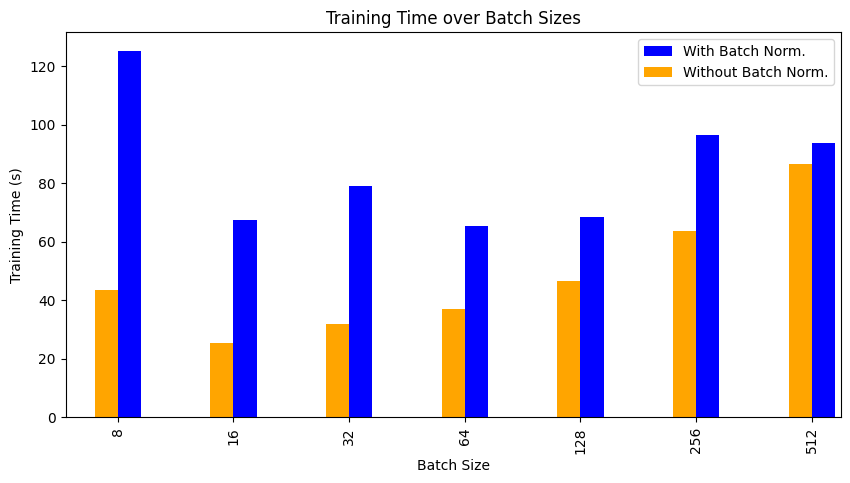

In [43]:
# Runtime plotting

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
width = 0.2

df[df.batchnorm].plot.bar(x='batch_size', y='runtime', color='blue', ax=ax, position=0, width=width)
df[~df.batchnorm].plot.bar(x='batch_size', y='runtime', color='orange', ax=ax, position=1, width=width)

ax.legend(['With Batch Norm.', 'Without Batch Norm.'])

ax.set_xlabel("Batch Size")
ax.set_ylabel("Training Time (s)")

plt.title("Training Time over Batch Sizes")

plt.savefig('runtime.png')
plt.show()

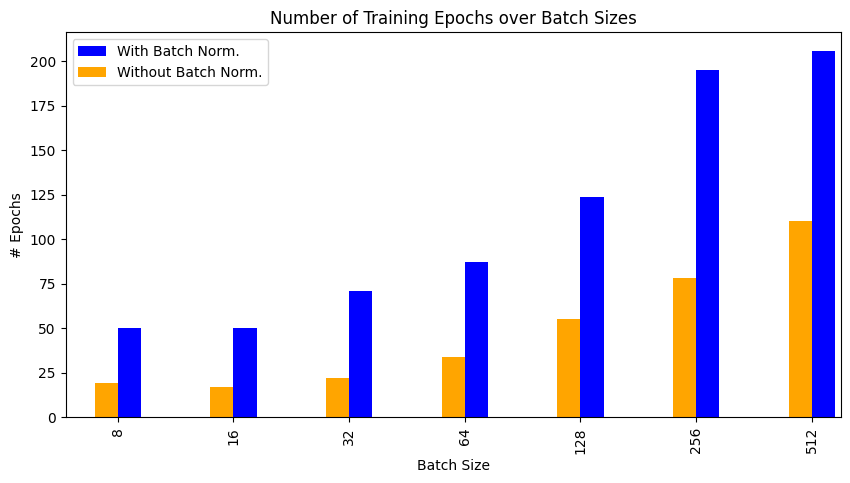

In [46]:
# Epoch numbers

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
width = 0.2

df[df.batchnorm].plot.bar(x='batch_size', y='epochs', color='blue', ax=ax, position=0, width=width)
df[~df.batchnorm].plot.bar(x='batch_size', y='epochs', color='orange', ax=ax, position=1, width=width)

ax.legend(['With Batch Norm.', 'Without Batch Norm.'])

ax.set_xlabel("Batch Size")
ax.set_ylabel("# Epochs")

plt.title("Number of Training Epochs over Batch Sizes")

plt.savefig('epochs.png')
plt.show()

## Plotting the loss for a model for inspection

In [47]:
with open('models/model_512_mini', 'rb') as f:
    m = pickle.load(f)

for i, c in enumerate(m['costs']):
    print(f"{(i + 1) * 100}. Train loss = {c:.5f}")

100. Train loss = 2.04713
200. Train loss = 1.96835
300. Train loss = 1.83709
400. Train loss = 1.77226
500. Train loss = 1.59711
600. Train loss = 1.56984
700. Train loss = 1.54434
800. Train loss = 1.46903
900. Train loss = 1.42682
1000. Train loss = 1.43157
1100. Train loss = 1.35693
1200. Train loss = 1.38343
1300. Train loss = 1.35528
1400. Train loss = 1.31660
1500. Train loss = 1.20676
1600. Train loss = 1.27836
1700. Train loss = 1.19854
1800. Train loss = 1.18971
1900. Train loss = 1.15425
2000. Train loss = 1.19524
2100. Train loss = 1.09824
2200. Train loss = 1.10596
2300. Train loss = 1.02904
2400. Train loss = 1.01947
2500. Train loss = 1.02697
2600. Train loss = 0.91865
2700. Train loss = 0.93111
2800. Train loss = 0.95184
2900. Train loss = 0.90703
3000. Train loss = 0.86857
3100. Train loss = 0.81475
3200. Train loss = 0.71764
3300. Train loss = 0.66119
3400. Train loss = 0.74310
3500. Train loss = 0.61947
3600. Train loss = 0.60429
3700. Train loss = 0.56177
3800. Trai

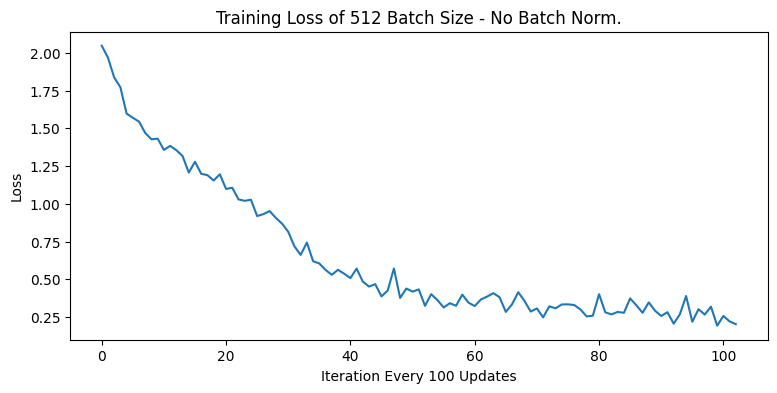

In [41]:
plt.figure(figsize=(9,4))
plt.plot(m['costs'])
plt.xlabel("Iteration Every 100 Updates")
plt.ylabel("Loss")
plt.title("Training Loss of 512 Batch Size - No Batch Norm.")
plt.savefig('training_loss.png')
plt.show()